### Задание к Уроку 7.  Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

- RFE - recursive feature elimination (есть в sklearn)
- Boruta - shadow features
- Target permutation

### Набор данных "Vinho Verde"

https://archive.ics.uci.edu/ml/datasets/wine+quality

Data Set Information:

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link] or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.


#### Attribute Information:

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


### Импорт данных

In [21]:
df = pd.read_csv('wine.csv')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


In [22]:
df.shape

(1599, 12)

> Соотношение классов

In [23]:
df['quality'].value_counts()

good    855
bad     744
Name: quality, dtype: int64

### Трансформация признаков

In [24]:
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
df['quality']=lb.fit_transform(df['quality'])
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### Разведочный анализ данных


In [25]:

# первый взгляд на параметр
def first_look(Series1, max_count=0, bins=10, quan=0.999, is_correct_outlier=False, is_show_stat=False):
    Series = Series1.copy()
    # простая корректировка по выбросам
    if is_correct_outlier:
        Series.drop(Series[Series > Series.quantile(quan)].index, inplace=True)
    # расчет основных значений
    Series_mean = round(Series.mean(), 2)
    Series_median = Series.median()
    Series_name = Series.name
    # расчет максимального выброса
    max_count = np.histogram(Series, bins=bins)[0].max()

    plt.figure(figsize=(16, 8))
    Series.hist(bins=bins)
    plt.ylabel('Count')
    plt.xlabel(Series_name)
    # отображение среднего и медианы
    y = np.linspace(0, max_count, bins)
    plt.plot([Series_mean] * bins, y, label='mean  : {:,.2f}'.format(Series_mean), linewidth=4)
    plt.plot([Series_median] * bins, y, label='median: {:,.2f}'.format(Series_median), linewidth=4)
    plt.legend()
    plt.title(Series_name + ' distribution')
    plt.show()
    if is_show_stat:
        print(Series.describe())

In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


> кодирование признаков не требуется

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [28]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

> Пропусков нет


fixed acidity


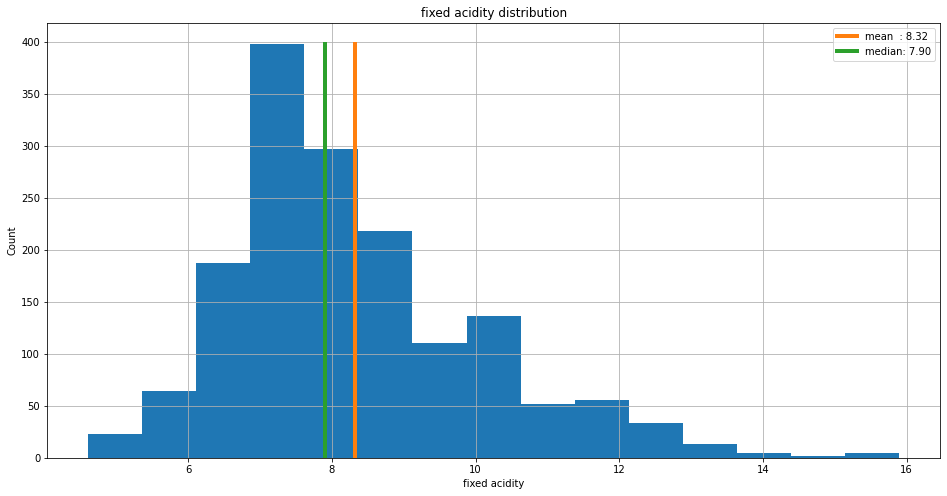

volatile acidity


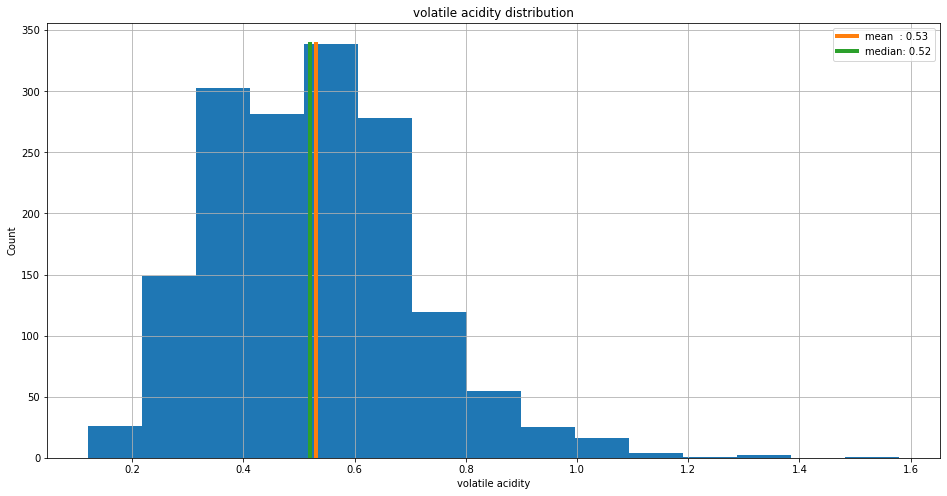

citric acid


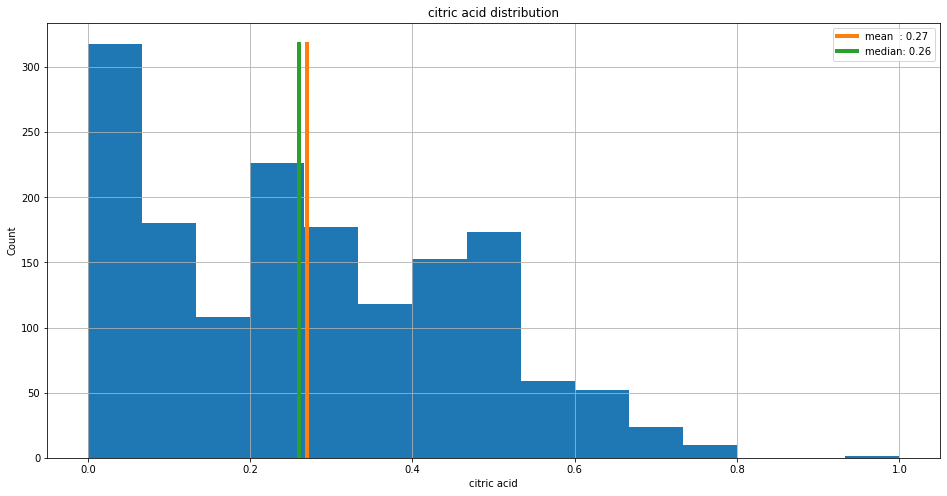

residual sugar


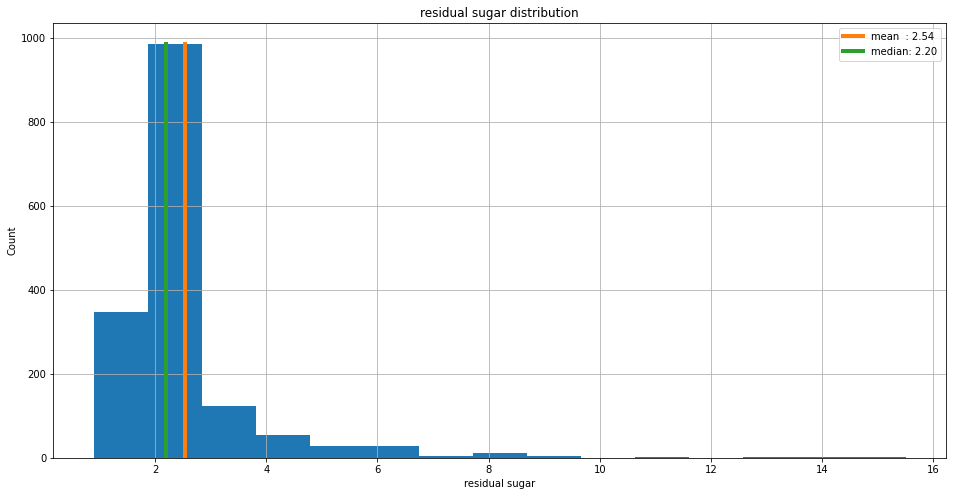

chlorides


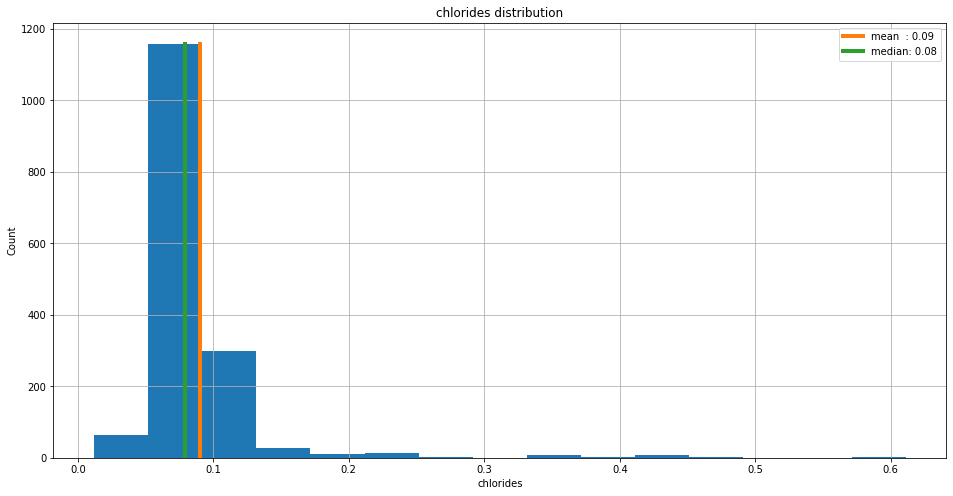

free sulfur dioxide


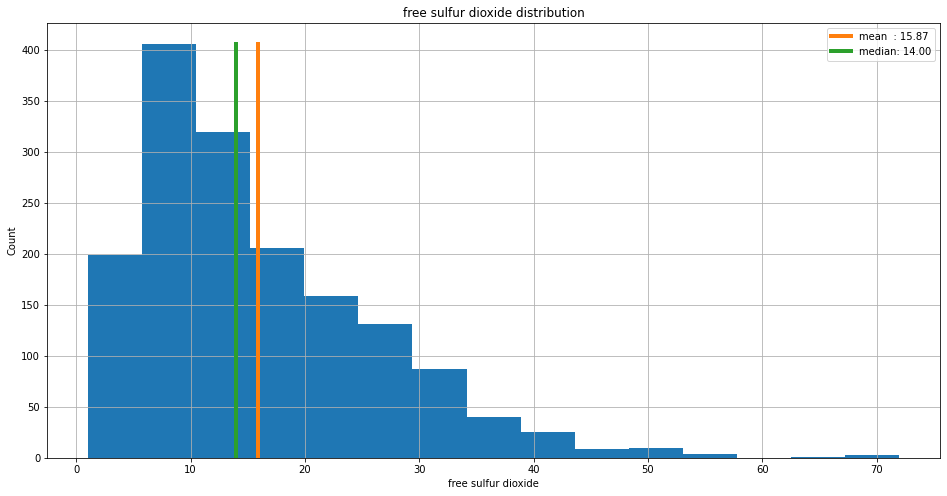

total sulfur dioxide


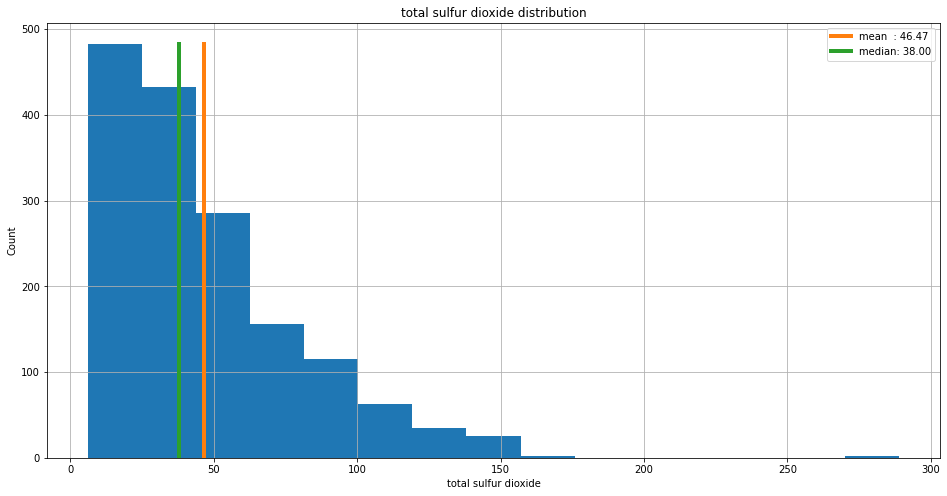

density


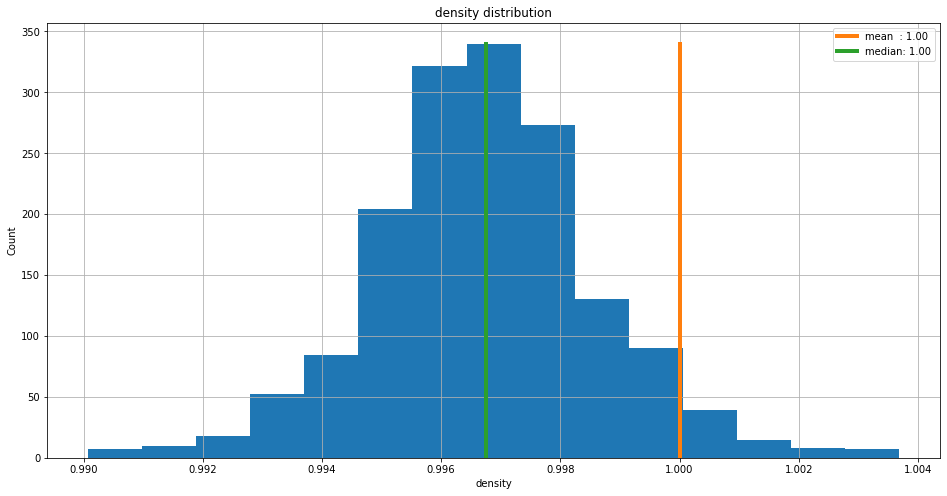

pH


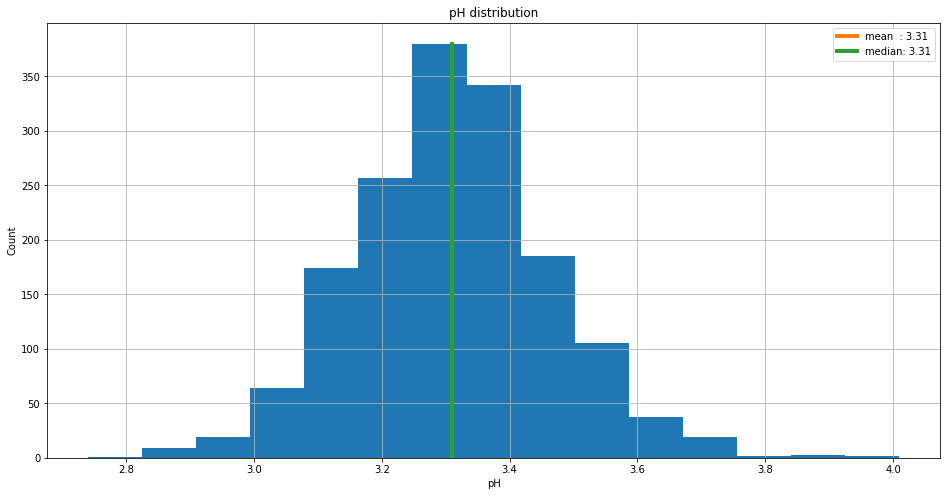

sulphates


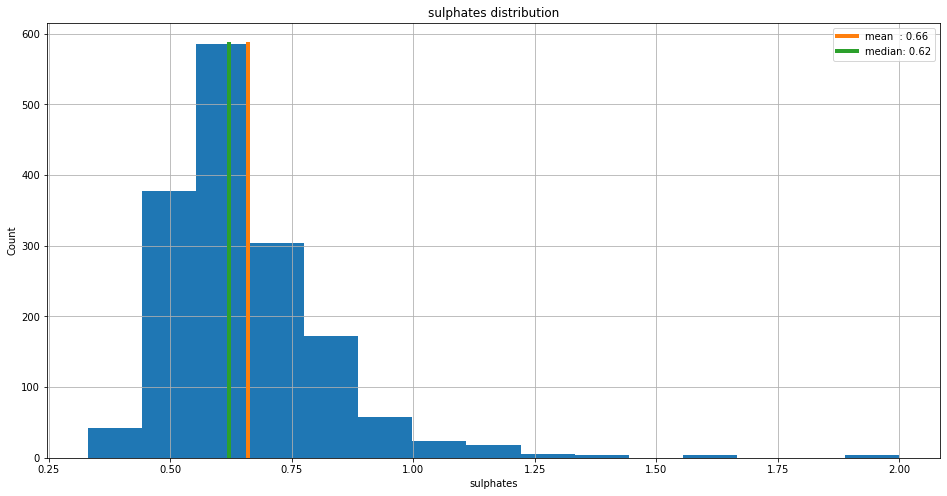

alcohol


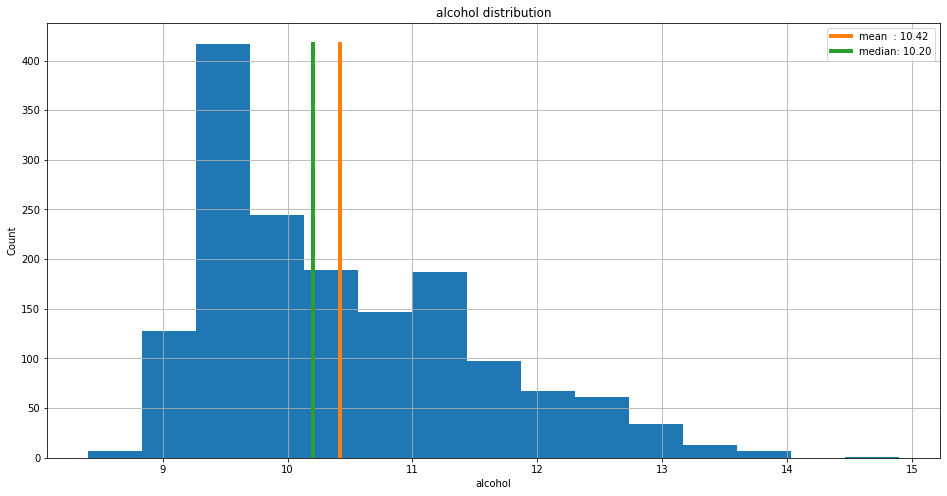

In [29]:
for feature in df.columns[:-1]:
    print(feature)
    first_look(df[feature], bins=15)

> При анализе признаков не наблюдаются выбросы. Медиана и срднее находятся близко к друг другу.

>Разбиваем выборку на тренировочную и тестовую части

In [30]:
from sklearn.model_selection import train_test_split

x_data = df.iloc[:, :-1]
y_data = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

### Обучаем модель

In [31]:
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder=False)

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[00:09:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


> Проверяем качество

In [32]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0))
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0))
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0))
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))


evaluate_results(y_test, y_predict)

Classification results:
f1: 84.41%
roc: 81.45%
recall: 83.96%
precision: 84.86%


### Интерпретация результатов с помощью SHAP

In [41]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
model = xgboost.train({"learning_rate": 0.01},
                      xgboost.DMatrix(x_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])



> показ картинки, в случае если не отработал скрипт js выше

<img src="force1.png"  />

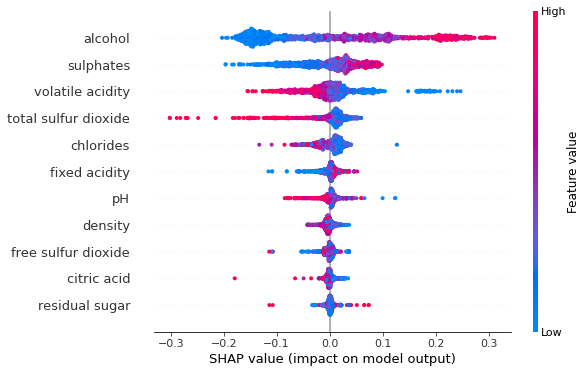

In [38]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train)

> Список признаков по приоритетам

11. alcohol - алкоголь
10. sulphates - сульфаты
2. volatile acidity - летучая кислотность
7. total sulfur dioxide - общий диоксид серы
5. chlorides -  хлориды

> **алкоголь** - вино с высоким уровнем алкоголя считается более качественным при сохранении технологии производства.
> Это призннаный факт
>
> **сульфаты** - наличие сульфатов в вине это признак того что вино созрело и стабилизировалось.
> https://vitis.academy/sulfites Сами по себе сульфаты не полезны
>
> **летучая кислотность** - формирует общий букет вина. Из-за этих
> соединений вино пахнет. https://winestyle.ru/articles/encyclopedia/acidity_of_wines.html
> Сами по себе соединения не полезны - это побочный результат выгонки
>
> **общий диоксид серы** - входит (присоединяется) к признаку **сульфаты**
>
> **хлориды** - наличие сидетельствует о возделывании винограда на засушливой
> почве. Закономерно, что в этом случае получаются более насыщенный всус.
> https://www.mt.com/ru/ru/home/supportive_content/ana_chem_applications/titration/AP015.html
>


